<a href="https://colab.research.google.com/github/kenbunroku/highway-removal/blob/main/highway_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Set up**

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:36
🔁 Restarting kernel...


In [ ]:
# Install osmnx
!apt install libspatialindex-dev
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (490 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

In [ ]:
# Import necessary libraries
import networkx as nx
import random
import numpy as np
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import osmnx as ox
from pyproj import CRS
import geopandas as gpd

### **Preprocessing Data**

**Import police arrest data to calculate a safety attribute later.**
Source:[Dallas Opendata](https://www.dallasopendata.com/Public-Safety/Police-Arrests/sdr7-6v3j)

In [ ]:
arrests = pd.read_csv('Police_Arrests.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,19,20,21,22,30,36,41,45,46,59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
arrests

,IncidentNum,ArrestYr,ArrestNumber,ArArrestDate,ArArrestTime,ArBkDate,ArLAddress,ArLApt,ArLZip,ArLCity,ArState,ArLCounty,ArLRA,ArLBeat,ArLDistrict,ArLSector,ArADOW,ArPremises,CFS_Number,ArOfcr1,ArOfcr2,Transport1,Transport2,Transport3,Search1,ArAction,ArWeapon,ArOSR,ArResisted,ArCurrLoc,ArCond,ArMedFlag,ArMedLoc,ArOpComm,ArresteeName,NickName,AliasName,BirthPlace,Age,AgeAtArrestTime,HAddress,HApt,HZIP,HCity,HState,HRA,HBeat,Height,Weight,Hair,Eyes,Race,Ethnic,Sex,Tatoo,TatooComment,Occupation,JobSchStatus,Employer,Drug,DrugRelated,DrugType,ClothingWorn,Expunged,UpZDate
0,104552-2020,2020,20-018820,06/14/2020 12:00:00 AM,09:30,06/14/2020 11:26:58 AM,1220 W MOCKINGBIRD LN,NaN,75247.0,DALLAS,TX,DALLAS,3100.0,514.0,2,510.0,Sun,Gas or Service Station,20-1067345,11312,11318,11318,11312,NaN,NaN,Arrested - Lew Sterrett,Unarmed,NaN,NaN,LS,NaN,NaN,NaN,NaN,"LEAL, SANTOS, LEE",NaN,NaN,"HOUSTON, TX",51.0,51.0,1818 CORSICANA ST,NaN,75201.0,DALLAS,TX,2088,135,5-09,180.0,White,Hazel,Hispanic or Latino,Non-Hispanic or Latino,Male,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,"BLUE TANK TOP, BLUE JEANS, YANKEES HAT",NaN,2020-06-14 11:33:57
1,128619-2020,2020,20-022381,07/23/2020 12:00:00 AM,02:56,07/23/2020 07:18:44 AM,4710 COYOTE TRL,NaN,75227.0,DALLAS,TX,DALLAS,1216.0,317.0,4,310.0,Thu,"Highway, Street, Alley ETC",20-1322490,10991,10896,10991,10896,NaN,NaN,Arrested - Lew Sterrett,Unarmed,NaN,NaN,LS,NaN,NaN,NaN,NaN,"SIERRA, MANUEL, ANGEL",NaN,NaN,DALLAS,21.0,21.0,3602 BYRD DR,NaN,75150.0,MESQUITE,TX,NaN,NaN,5-08,195.0,Black,Brown,Hispanic or Latino,Non-Hispanic or Latino,Male,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,"NO SHIRT, SHORTS, NIKE",NaN,2020-07-23 07:28:21
2,075650-2020,2020,20-013865,04/27/2020 12:00:00 AM,23:00,04/28/2020 01:52:14 AM,3016 CEDAR LAKE DR,NaN,75227.0,DALLAS,TX,DALLAS,1236.0,321.0,4,320.0,Mon,"Highway, Street, Alley ETC",20-0757590,11157,11078,11228,11284,NaN,NaN,Arrested - Lew Sterrett,Unarmed,NaN,NaN,LS,NaN,NaN,NaN,NaN,"FLORES CANDELARIO, JORGE, ALFREDO",NaN,NaN,NaN,20.0,20.0,2783 JERRIDEE CIR,NaN,75229.0,DALLAS,TX,3015,552,5-06,200.0,Black,Brown,Hispanic or Latino,Non-Hispanic or Latino,Male,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,WHITE SHIRT,NaN,2020-04-28 02:03:23
3,095586-2019,2019,19-016816,05/14/2019 12:00:00 AM,01:25,05/14/2019 04:06:27 AM,9731 TREVOR DR,NaN,75243.0,DALLAS,TX,DALLAS,9602.0,254.0,10,250.0,Tue,Single Family Residence - Occupied,19-0856716,8035,7897,10224,10066,NaN,NaN,Arrested - Lew Sterrett,Unarmed,NaN,NaN,LS,NaN,NaN,NaN,NaN,"PACKAT, PATRICE, MARCK",NaN,NaN,REPUBLIC OF GABONAISE,23.0,23.0,12284 ABRAMS RD,805,75243.0,DALLAS,TX,9601,253,5-10,140.0,Brown,Brown,Black,Non-Hispanic or Latino,Male,NaN,NaN,NaN,NaN,NaN,NaN,Uknown,NaN,"WHITE TSHIRT, BLACK SWEATPANTS, BLACK SOCKS, N...",NaN,2019-05-14 11:55:41
4,200450-2021,2021,21-033402,11/04/2021 12:00:00 AM,15:49,11/04/2021 07:41:58 PM,3207 KIRNWOOD DR,116,75237.0,DALLAS,TX,DALLAS,4381.0,745.0,8,740.0,Thu,Restaurant/Food Service/TABC Location,21-2117754,11926,11919,11919,NaN,NaN,NaN,Arrested - Lew Sterrett,Gun,NaN,NaN,LS,NaN,NaN,NaN,NaN,"DAWKINS, BREANNA, SHANAY",NaN,NaN,NaN,29.0,29.0,421 KIRNWOOD DR,NaN,75232.0,DALLAS,TX,4364,747,5-07,175.0,Brown,Brown,Black,Non-Hispanic or Latino,Female,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,"BLEACH BLK SHIRT, BLK/WHITE PNTS, AND SLIDES",NaN,2021-11-06 06:49:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90183,174066-2017,2017,17-031482,07/31/2017 12:00:00 AM,18:20,07/31/2017 08:06:15 PM,2300 BOMAR AVE,NaN,75235.0,DALLAS,TX,DALLAS,3093.0,513.0,2,510.0,Mon,"Highway, Street, Alley ETC",17-1456426,11225,8310,11225,8310,NaN,NaN,Arrested - CDC,None,NaN,NaN,DX,NaN,NaN,NaN,NaN,"JINEZ, JUAN, C",NaN,NaN,NaN,36.0,36.0,7261 PINEBERRY RD,NaN,75249.0,DALLAS,TX,8811,436,5-11,250.0,Black,Brown,Hispanic or Latino,Hispanic or Latino,Male,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
# Delete na from "ArLZip"
arrests2 = arrests.dropna(axis=0, subset=['ArLZip'])

In [ ]:
# Count the number of cases by Zipcodes
arrestHistogram = (arrests2['ArLZip'].value_counts()).to_frame()
arrestHistogram.reset_index(inplace=True)
arrestHistogram.columns = ["ArLZip","COUNT"]

arrestHistogram['ArLZip'] = arrestHistogram['ArLZip'].astype(int)

In [ ]:
arrestHistogram

,ArLZip,COUNT
0,75201,6432
1,75220,5404
2,75216,4976
3,75202,4568
4,75215,4076
...,...,...
105,76107,1
106,76111,1
107,75089,1
108,75056,1


In [ ]:
mean = arrestHistogram['COUNT'].mean()

# Calculate safety index by zipcodes
arrestHistogram['Index'] = (arrestHistogram['COUNT'] / mean)
arrestHistogram['Index']  = np.round(arrestHistogram['Index'], 2)
arrestHistogram

,ArLZip,COUNT,Index
0,75201,6432,7.85
1,75220,5404,6.59
2,75216,4976,6.07
3,75202,4568,5.57
4,75215,4076,4.97
...,...,...,...
105,76107,1,0.00
106,76111,1,0.00
107,75089,1,0.00
108,75056,1,0.00


**Import geojson data of zipcodes in Dallas.**
Source: [City of Dallas EGIS](https://gis.dallascityhall.com)

In [ ]:
zipcodes = gpd.read_file('DallasZipCodes.geojson')

In [ ]:
zipcodes

,FID,SHAPEarea,SHAPElen,ZipCode,Shape__Area,Shape__Length,geometry
0,1,7.823290e+08,188488.485863,75052,102861207.0,67779.372261,"POLYGON ((-97.02226 32.70955, -97.01545 32.709..."
1,2,4.058359e+08,128778.324355,75051,53468868.5,46619.682435,"POLYGON ((-96.92617 32.74964, -96.92626 32.747..."
2,3,1.565419e+08,61258.583398,75287,20720193.0,22155.859453,"POLYGON ((-96.81625 33.01244, -96.81650 33.010..."
3,4,1.096577e+09,237178.416772,75104,143943874.5,84938.694573,"POLYGON ((-96.97987 32.65623, -96.97380 32.643..."
4,5,1.213448e+08,50609.633095,75205,16017083.5,18373.865820,"POLYGON ((-96.79006 32.85119, -96.79001 32.850..."
5,6,7.128640e+07,45444.818954,75204,9401436.0,16483.143153,"POLYGON ((-96.79874 32.81939, -96.79653 32.818..."
6,7,1.325127e+08,70219.592261,75203,17446854.5,25447.021820,"POLYGON ((-96.80203 32.76010, -96.79975 32.758..."
7,8,1.960392e+07,39348.120198,75202,2576171.0,14270.979376,"POLYGON ((-96.81148 32.79087, -96.81012 32.788..."
8,9,4.035452e+07,48648.730570,75201,5326536.0,17631.720385,"POLYGON ((-96.80585 32.80201, -96.80546 32.800..."
9,10,1.700087e+08,63158.627255,75137,22341507.5,22822.858329,"POLYGON ((-96.88448 32.64752, -96.88706 32.645..."


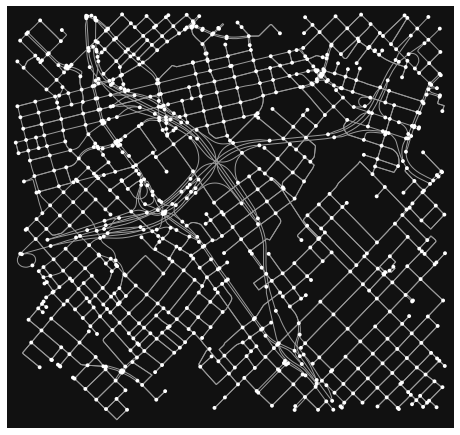

In [ ]:
# Create a motorway graph from boudary box
north, south, east, west = 32.7886, 32.7626, -96.7641, -96.7977
transport_mode = 'drive'

graph = ox.graph_from_bbox(north, south, east, west, network_type=transport_mode)
fig, ax = ox.plot_graph(graph)

Coordinate system: +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


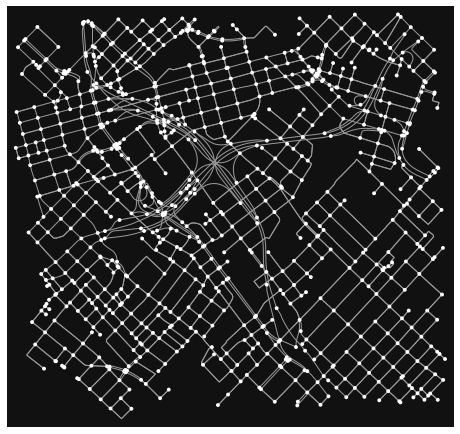

In [ ]:
# Project the data
G = ox.project_graph(graph)

# Find the largetst network connected
largest_graph = list(max(nx.strongly_connected_components(G), key=len))
# Create a list that contains nodes not in the largest graph
removed_nodes = list(G.nodes())
for n in largest_graph:
  removed_nodes.remove(n)
# Remove the nodes from the original graph
G.remove_nodes_from(removed_nodes)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(G, nodes=True, edges=True)
print("Coordinate system:", edges_proj.crs)

fig, ax = ox.plot_graph(G)

In [ ]:
# Indentify which zipcode each edge belongs to
collector = []
from shapely.geometry import Point

count = 0
for edge in list(G.edges):
  start = [G.nodes[edge[0]]["lon"], G.nodes[edge[0]]["lat"]]
  end = [G.nodes[edge[1]]["lon"], G.nodes[edge[1]]["lat"]]
  midPoint = [((start[0]+end[0])/2), ((start[1]+end[1])/2)]
  geoPoint =  gpd.points_from_xy([midPoint[0]], [midPoint[1]])
  # print(count, geoPoint[0])
  count += 1
  for index, zip in zipcodes.iterrows():
    gdf = gpd.GeoDataFrame(index=[0], crs='epsg:6354', geometry= [zip.loc["geometry"]])
    if gdf.contains(geoPoint[0])[0]:
      match = arrestHistogram.loc[arrestHistogram["ArLZip"] == zip.ZipCode].to_dict('records')
      collector.append(match[0])
      # print(match[0])
      break
  if len(collector) != count:
    match = {'ArLZip': 'NaN', 'COUNT': 0, 'Index': 0.0}
    collector.append(match)
    print(count - 1)

print(collector)

56
[{'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75204, 'COUNT': 3770, 'Index': 4.6}, {'ArLZip': 75226, 'COUNT': 2276, 'Index': 2.78}, {'ArLZip': 75226, 'COUNT': 2276, 'Index': 2.78}, {'ArLZip': 75226, 'COUNT': 2276, 'Index': 2.78}, {'ArLZip': 75201, 'COUNT': 6432, 'Index': 7.85}, {'ArLZip': 75226, 'COUNT': 2276,

In [ ]:
# Manually input missing datum
collector[56] = arrestHistogram.loc[arrestHistogram["ArLZip"] == 75201].to_dict('records')[0]
collector[56]

{'ArLZip': 75201, 'COUNT': 6432, 'Index': 7.85}

In [ ]:
# Check if all the edges has the attributes
print(len(list(G.edges)), len(collector))

2140 2140


### **Main code for a generator**

**Set edge attributes**

In [ ]:
def set_edge_attribute():
  # impute speed on all edges missing data
  ox.add_edge_speeds(G)
  # calculate travel time (seconds) for all edges
  ox.add_edge_travel_times(G)

  # Set Construction attribute randomly
  const_num = 5
  const_index = np.random.choice(len(G.edges()), const_num, replace=False)
  for index in const_index:
    attr = {(list(G.edges())[index][0], list(G.edges())[index][1], 0): {'const': True}}
    nx.set_edge_attributes(G, attr)
  # print(nx.get_edge_attributes(G, 'const'))

  # Set Congestion atrribute on each edge
  i = 0
  for u, v, d in G.edges(data=True):
    d['congestion'] = 0
    # print(i)
    # Set Safety attribute
    d['safety'] = collector[i]['Index']
    i += 1
  # print(nx.get_edge_attributes(G, 'safety'))

**Create vehicles that move inside the network**

In [ ]:
def build_vehicle(num, nodes_list):
  # Make a list of vehicles
  vehicles = []

  # Set the number of vehicles
  seed = random.randint(1, 100)
  np.random.seed(seed)
  src_tgt = np.random.choice(len(nodes_list), num * 2, replace=False)

  for i in range(num):
    vehicle = {}

    # Choose starting location
    src, tgt = list(nodes_list)[src_tgt[i * 2]], list(nodes_list)[src_tgt[(i * 2) + 1]]

    # Build vehicle
    vehicle['src'] = src
    vehicle['tgt'] = tgt
    vehicle['loc'] = src
    vehicle['steps'] = [src]
    vehicle['completed'] = False

    # Make an unknownness attribute
    H = G.copy()
    for u, v, d in H.edges(data=True):
      # Clear existing attributes
      d.clear()
      # Set the new attribute
      d['unknownness'] = 0
    # Insert the edges as an attribute of vehicle
    vehicle['unknownness'] = H.edges

    # Save entity to array
    vehicles.append(vehicle)

  return vehicles, src_tgt

**Transit simulation**

In [ ]:
def transit(vehicles, highways, removal = False):
  def move_vehicle(vehicles):
      simulationCount = 0
      while True:
        if sum([vehicle['completed'] for vehicle in vehicles]) == num:
          break

        for vehicle in vehicles:
          #Check for completed journey and skip vehicle if so
          if vehicle['completed'] == True:
            continue
          
          if vehicle['tgt'] in list(G.nodes()):
            obs = []
            # Check the current locations of other vehicles as obstacles for next step
            for j in range(len(vehicles)):
              o = vehicles[j]['loc']
              obs.append(o)

            # Set the heuristic function 
            def dist(a, b):
              # Extract geometry data in geoseries format
              src_geo = nodes_proj.loc[a]['geometry']
              tgt_geo = nodes_proj.loc[b]['geometry']

              # Calculate distance by using geopanda methods
              dist = src_geo.distance(tgt_geo) / 1609.344 # meters to miles
              return dist

            # Set the cost function
            def cost(a, b, k1=1.0, k2=10.0, kind='intsct'):
                # Calculate distance
                src_geo = nodes_proj.loc[a]['geometry']
                tgt_geo = nodes_proj.loc[b]['geometry']
                dist = src_geo.distance(tgt_geo) / 1609.344 # meters to miles
                
                # Impose a huge penalty when vehicle is gonna overlap on the same node
                if any([(a == o or b == o) for o in obs]):
                    penalty = 1.0e6
                else:
                    penalty = 0.0

                # Extract the attributes for weight calculation
                safety = G.edges[a, b, 0]['safety']
                congestion = G.edges[a, b, 0]['congestion']
                unknownness = vehicle['unknownness'][a, b, 0]['unknownness']
                travel_time = G.edges[a, b, 0]['travel_time']
                # lanes = G.edges[a, b, 0]['lanes']

                # Set a huge cost on the construction edge
                const = 1.0e6

                # Extract attribute keys for dictionary switch
                # Change dict_keys to tuple because dect_keys are unhashable in dictionary
                edge_attributes = tuple(G.get_edge_data(a, b).keys())

                def cost_with_const():
                  return dist + penalty + const + safety + congestion + unknownness + travel_time

                def default():
                  return dist + penalty + safety + congestion + unknownness + travel_time

                # Use dictionary switch because match switch is only available in Python 3.10
                # Python version available in google colab is 3.7
                def switch(edge_attributes):
                  dict = {
                    ('highway', 'const', 'safety'): cost_with_const()
                  }
                  return dict.get(edge_attributes, default())
                return switch(edge_attributes)
            
            for u, v, d in G.edges(data=True):
                d['weight'] = cost(u, v)

            # Identify next move
            nextStep = nx.astar_path(G, vehicle["loc"], vehicle["tgt"], dist, weight='weight')[1]
           
            # Increase congestion on the edges where the vehicle passes
            G.edges[vehicle["loc"], nextStep, 0]['congestion'] += 1
            
            # Decrease unknownness of the vehicle on the edges where it passes
            vehicle['unknownness'][vehicle["loc"], nextStep, 0]['unknownness'] -= 1

            #Update location and linked edges
            vehicle['loc'] = nextStep
            vehicle['steps'].append(nextStep)

            if vehicle['loc'] == vehicle['tgt']:
              # Highlight the source aned the target
              G.nodes[vehicle['src']]['color'] = 'green'
              G.nodes[vehicle['tgt']]['color'] = 'red'

              # Save step edges
              vehicle['steps_edges'] = []
              for i in range(len(vehicle['steps']) -1):
                edge = (vehicle['steps'][i], vehicle['steps'][i+1], 0)
                vehicle['steps_edges'].append(edge)
              
              # Save travel distance
              vehicle['travel_length'] = sum([G.edges[step]['length'] for step in vehicle['steps_edges']]) / 1609.344 # meters to miles

              # Calculate and carbon emissions based on travel length
              vehicle['carbon_emissions'] = 404 * vehicle['travel_length'] # grams

              # Save travel time
              vehicle['travel_time'] = sum([G.edges[step]['travel_time'] for step in vehicle['steps_edges']]) / 60 # minutes

              vehicle['completed'] = True
              simulationCount += 1
              print("Simulation step: " + str(simulationCount))

  if removal == False:
    move_vehicle(vehicles)

    # Create a list of dictonary to save the result
    generations = [{}]
    generations[0]['vehicles'] = vehicles
    generations[0]['highways'] = highways
    generations[0]['edges'] = G.edges(data=True)
    generations[0]['ave_travel_length'] = np.round(sum([vehicle['travel_length'] for vehicle in vehicles]) / len(vehicles), 2)
    generations[0]['ave_travel_time'] = np.round(sum([vehicle['travel_time'] for vehicle in vehicles]) / len(vehicles), 2)
    generations[0]['ave_carbon_emissions'] = np.round(sum([vehicle['carbon_emissions'] for vehicle in vehicles]) / len(vehicles), 2)
    return generations
  
  else:
    count = 0
    generations = []
    # Loop cutting highways until going through all the highways
    while True:
      if count == len(highways):
        break

      for h in highways:
        # Remove a highway from the list
        highways.remove(h)
        for u, v in h['edges']:
          # Remove a highway from the graph
          G.remove_edge(u, v)

        # Find the largetst network connected
        largest_graph = list(max(nx.strongly_connected_components(G), key=len))
        vehicles, src_tgt = build_vehicle(num, largest_graph)

        # Run the transit simulator
        move_vehicle(vehicles)

        # Save the result
        generation = {}
        generation['vehicles'] = vehicles
        generation['removed_highway'] = h['edges']
        generation['highways'] = highways
        generation['edges'] = G.edges(data=True)
        generation['ave_travel_length'] = np.round(sum([vehicle['travel_length'] for vehicle in vehicles]) / len(vehicles), 2)
        generation['ave_travel_time'] = np.round(sum([vehicle['travel_time'] for vehicle in vehicles]) / len(vehicles), 2)
        generation['ave_carbon_emissions'] = np.round(sum([vehicle['carbon_emissions'] for vehicle in vehicles]) / len(vehicles), 2)
        generations.append(generation)
       
        # Restore the highway removed to the list
        highways.insert(count, h)

        # Restore the original graph
        G.add_edges_from(h['edges_attributes'])

        count += 1
        print("Remove simulation: " + str(count))
    return generations

**Visualizing congestions**

In [ ]:
def draw_network(removal):
  count = 1
  vehicles_steps = []
  for g in generations:
    vehicles_steps.clear()
    print("Graph:" + str(count))
    
    for vehicle in g['vehicles']:
      vehicles_steps.append(vehicle['steps'])

    # Highlight the path
    ox.plot_graph_routes(
      G,
      routes=vehicles_steps,
      route_colors="orange",
      route_linewidth=4,
      route_alpha=0.4)
    
    if removal == True:
      hc = []
      for u, v in G.edges():
        if (u, v) in g['removed_highway']:
          hc.append('r')
        else:
          hc.append('#999999')
      
      ox.plot_graph(
          G,
          edge_color=hc,
          edge_linewidth=2
          )
    count += 1

### **Execution**

**Identify highways in the target area**

In [ ]:
highways = [(u, v, d) for u, v, d in G.edges(data=True) if d['highway'] == 'motorway']

In [ ]:
highways_by_name = []
for u, v, d in highways:
  if not any(h['name'] == d['name'] for h in highways_by_name):
    highway = {'name': d['name'], 'edges': [(u, v)], 'edges_attributes': [(u, v, d)]}
    highways_by_name.append(highway)
  else:
    for h in highways_by_name:
      if h['name'] == d['name']:
        h['edges'].append((u, v))
        h['edges_attributes'].append((u, v, d))
print(highways_by_name)

[{'name': 'East R L Thornton Freeway', 'edges': [(81540741, 81547172), (81547172, 81542067), (81542067, 82120054), (81547293, 81597066), (81597066, 81549231), (81549231, 1388359736), (1388359736, 82120655), (81589819, 1388359735), (81578831, 81585085), (81585085, 81547293), (1388359735, 81622259), (81622259, 81540741)], 'edges_attributes': [(81540741, 81547172, {'osmid': [90703204, 513704814], 'oneway': True, 'name': 'East R L Thornton Freeway', 'highway': 'motorway', 'length': 550.057, 'lanes': '5', 'geometry': <shapely.geometry.linestring.LineString object at 0x7efef92a30d0>, 'bridge': 'yes', 'ref': 'I 30;US 67', 'maxspeed': '55 mph'}), (81547172, 81542067, {'osmid': [180775013, 513704813], 'oneway': True, 'name': 'East R L Thornton Freeway', 'highway': 'motorway', 'length': 596.4839999999999, 'lanes': '4', 'geometry': <shapely.geometry.linestring.LineString object at 0x7efef92a3350>, 'bridge': 'yes', 'ref': 'I 30;US 67', 'maxspeed': '55 mph'}), (81542067, 82120054, {'osmid': 5137048

In [ ]:
for h in highways_by_name:
  print(h['name'])

East R L Thornton Freeway
I 30 HOV
Julius Schepps Freeway


**Execute the generator**

In [ ]:
set_edge_attribute()

In [ ]:
num = 20
vehicles, src_tgt = build_vehicle(num, G.nodes())

In [ ]:
removal = True
generations = transit(vehicles, highways_by_name, removal)

Simulation step: 1
Simulation step: 2
Simulation step: 3
Simulation step: 4
Simulation step: 5
Simulation step: 6
Simulation step: 7
Simulation step: 8
Simulation step: 9
Simulation step: 10
Simulation step: 11
Simulation step: 12
Simulation step: 13
Simulation step: 14
Simulation step: 15
Simulation step: 16
Simulation step: 17
Simulation step: 18
Simulation step: 19
Simulation step: 20
Remove simulation: 1
Simulation step: 1
Simulation step: 2
Simulation step: 3
Simulation step: 4
Simulation step: 5
Simulation step: 6
Simulation step: 7
Simulation step: 8
Simulation step: 9
Simulation step: 10
Simulation step: 11
Simulation step: 12
Simulation step: 13
Simulation step: 14
Simulation step: 15
Simulation step: 16
Simulation step: 17
Simulation step: 18
Simulation step: 19
Simulation step: 20
Remove simulation: 2
Simulation step: 1
Simulation step: 2
Simulation step: 3
Simulation step: 4
Simulation step: 5
Simulation step: 6
Simulation step: 7
Simulation step: 8
Simulation step: 9
Simul

Graph:1


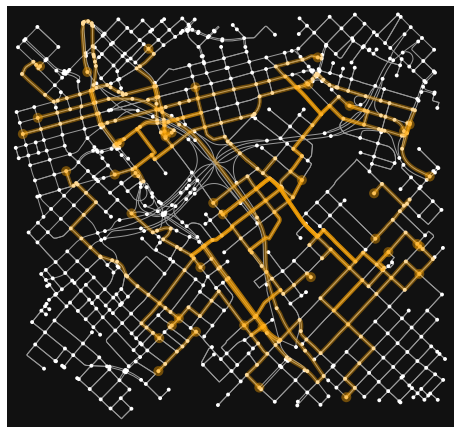

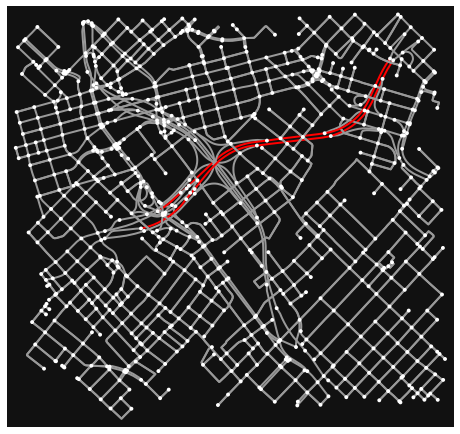

Graph:2


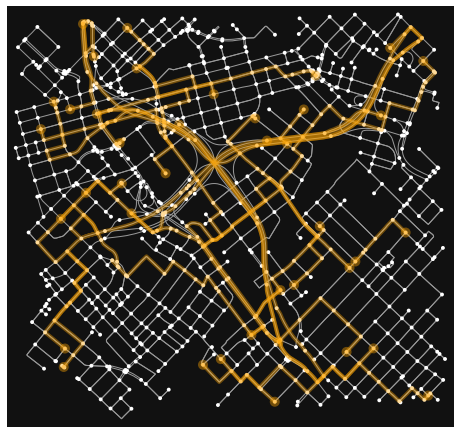

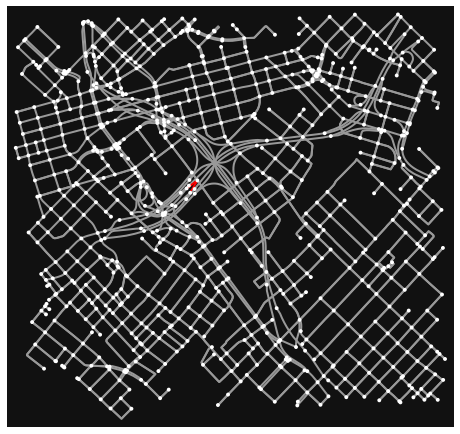

Graph:3


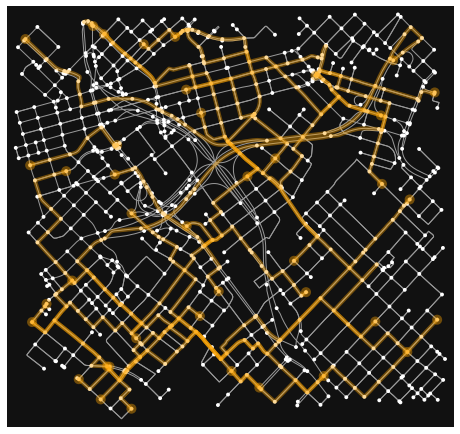

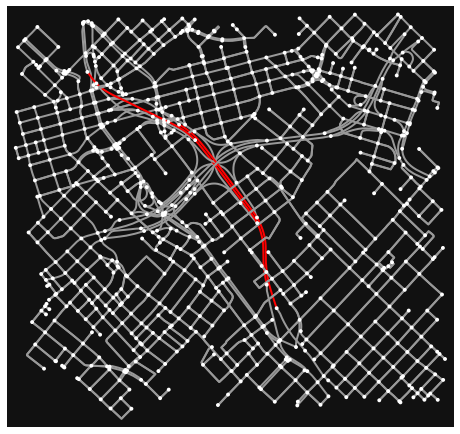

In [ ]:
draw_network(removal)